In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets==1.0.1
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import csv
from datasets import load_dataset, load_metric
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from gensim.parsing.preprocessing import preprocess_string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
!pip install transformers
from transformers import BertModel
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Mounted at /content/drive
     |████████████████████████████████| 1.8 MB 13.2 MB/s 
     |████████████████████████████████| 243 kB 54.9 MB/s 


PyTorch version 1.9.0+cu102 available.
TensorFlow version 2.5.0 available.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 2.6 MB 11.4 MB/s 
     |████████████████████████████████| 636 kB 45.0 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
LDA_alpha = 1
max_len = 30
LDA_Topic_count = 80
batch = 32
lr = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Microsoft Research Paraphrase dataset

In [3]:
dataset = load_dataset('glue', 'mrpc')

https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/glue.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmpizwg8sqo


storing https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/glue.py in cache at /root/.cache/huggingface/datasets/8a575b8341116e1cf0f3a928d70f7ee7ec1aee5e6620744d30d5331a2be68979.d804a9b67563ab7de5bb068d5eccc0eff8cf0849041ad2e8afff1beb8a14544d.py
creating metadata file for /root/.cache/huggingface/datasets/8a575b8341116e1cf0f3a928d70f7ee7ec1aee5e6620744d30d5331a2be68979.d804a9b67563ab7de5bb068d5eccc0eff8cf0849041ad2e8afff1beb8a14544d.py


https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/dataset_infos.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp4a6kfinc


storing https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/dataset_infos.json in cache at /root/.cache/huggingface/datasets/e9129383f6197a6e76ba55cb5a1dfc2cc28e085b4585b48a3cf8978344805837.03e16a366649d9f5c63e615ccbc58466c013cc8677c5be1b52636c46e597c13c
creating metadata file for /root/.cache/huggingface/datasets/e9129383f6197a6e76ba55cb5a1dfc2cc28e085b4585b48a3cf8978344805837.03e16a366649d9f5c63e615ccbc58466c013cc8677c5be1b52636c46e597c13c
Checking /root/.cache/huggingface/datasets/8a575b8341116e1cf0f3a928d70f7ee7ec1aee5e6620744d30d5331a2be68979.d804a9b67563ab7de5bb068d5eccc0eff8cf0849041ad2e8afff1beb8a14544d.py for additional imports.
Creating main folder for dataset https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/glue.py at /root/.cache/huggingface/modules/datasets_modules/datasets/glue
Creating specific version folder for dataset https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/glue/glue.py at /root/.cache/hugg

Dataset not on Hf google storage. Downloading and preparing it from source
  0%|          | 0/3 [00:00<?, ?it/s]Couldn't get ETag version for url https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc
https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmpvw7by8ik


storing https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc in cache at /root/.cache/huggingface/datasets/downloads/8d220c9428aab35412988ca4af82113e71078cfb86c00cf98b8d2ff0af54d19f
creating metadata file for /root/.cache/huggingface/datasets/downloads/8d220c9428aab35412988ca4af82113e71078cfb86c00cf98b8d2ff0af54d19f
 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]

https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmp3qjn01z4


storing https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt in cache at /root/.cache/huggingface/datasets/downloads/7c6c4f66e416181b62e136ddd5834ec10afe3aac4f7a327b81ca74025ea69529
creating metadata file for /root/.cache/huggingface/datasets/downloads/7c6c4f66e416181b62e136ddd5834ec10afe3aac4f7a327b81ca74025ea69529
 67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmpx8592kmm


storing https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt in cache at /root/.cache/huggingface/datasets/downloads/d0f75e90c732a9847ec38471fddece4ebcaad09dd1958467e2b00c6a3cbd31a9
creating metadata file for /root/.cache/huggingface/datasets/downloads/d0f75e90c732a9847ec38471fddece4ebcaad09dd1958467e2b00c6a3cbd31a9
100%|██████████| 3/3 [00:06<00:00,  2.07s/it]
Checksum Computation took 0.0 min
All the checksums matched successfully for dataset source files
Generating split train


Done writing 3668 examples in 943851 bytes /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542.incomplete/glue-train.arrow.
Generating split validation


Done writing 408 examples in 105887 bytes /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542.incomplete/glue-validation.arrow.
Generating split test


Done writing 1725 examples in 442418 bytes /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542.incomplete/glue-test.arrow.
All the splits matched successfully.
Constructing Dataset for split train, validation, test, from /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542


Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 193.08it/s]


In [4]:
counter = {}
for text in dataset['train']['sentence1']:
    tokens = word_tokenize(text)
    for t in tokens:
        if t in counter.keys():
            counter[t] = counter[t] + 1
        else:
            counter[t] = 0
for text in dataset['train']['sentence2']:
    tokens = word_tokenize(text)
    for t in tokens:
        if t in counter.keys():
            counter[t] = counter[t] + 1
        else:
            counter[t] = 0
for i in range(len(dataset['train'])):
    l1 = [x for x in word_tokenize(dataset['train']['sentence1'][i]) if counter[x] < 270]
    l2 = [x for x in word_tokenize(dataset['train']['sentence2'][i]) if counter[x] < 270]
    dataset['train']['sentence1'][i] = ' '.join(l1)
    dataset['train']['sentence2'][i] = ' '.join(l2)

In [5]:
delet = []
for i in range(len(dataset['train'])):
    l1 = len(word_tokenize(dataset['train']['sentence1'][i]))
    l2 = len(word_tokenize(dataset['train']['sentence2'][i]))
    if l1 > 200 or l2 < 3 or l1 < 3 or l2 > 200:
        delet.append(i)
for i in reversed(delet):
    del dataset['train']['sentence1'][i]
    del dataset['train']['sentence2'][i]
    del dataset['train']['label'][i]
print(reversed(delet))

In [6]:
split = dataset['train'].train_test_split(test_size=0.1, seed=1)
train = split['train']
test = split['test']
val = dataset['validation']

Caching indices mapping at /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542/cache-07d9805862391d7d.arrow
Done writing 3301 indices in 105632 bytes /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542/tmpkd3pwzyv.
Caching indices mapping at /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542/cache-f52efb2f4d4c4edb.arrow
Done writing 367 indices in 2936 bytes /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/930e9d141872db65102cabb9fa8ac01c11ffc8a1b72c2e364d8cdda4610df542/tmpnddtib5h.


### LDA

In [7]:
def LDA(data_words,per_word_topics,alpha,num_topics):#per word?
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=num_topics, 
                                              random_state=100,
                                              update_every=1,
                                              chunksize=100,
                                              passes=10,
                                              alpha=alpha,#alpha='auto'
                                              per_word_topics=per_word_topics, minimum_probability=1e-8)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return lda_model, id2word, lda_model.log_perplexity(corpus) ,coherence_lda

In [8]:
import unicodedata
def normalizer(text):
    words = word_tokenize(text)
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_word = new_word.lower()
        if not new_word.isdigit():
            new_words.append(new_word)
    text = ' '.join(new_words)
    text = text.replace('<url>',"").replace("-"," ").replace(" i'm "," ").replace(" that's "," ").replace(" i'll "," ").replace(" i've "," ").replace(" can't "," ").replace('<img>',"").replace("\"","").replace("“","").replace("”","").replace("½","")
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
lemmatizer = WordNetLemmatizer()
def LDAprocess(texts):
    tokens = []
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    for text in texts:
        text = normalizer(text)
        token = word_tokenize(lemmatizer.lemmatize(text))
        noninformative = ["can't","i've","i'll","i'm","that's"]
        token = [word for word in token if word not in noninformative]
        tokens.append(token)
    return tokens

In [10]:
train_LDA = LDAprocess(train['sentence1']+train['sentence2'])
lda_model , id2word, _, _ = LDA(train_LDA,True,LDA_alpha,LDA_Topic_count)

### network

In [11]:
class EarlyStopping():
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_f1 = None
        self.early_stop = False
    def __call__(self, val_loss, val_f1):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_f1 = val_f1
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_f1 - val_f1 < self.min_delta:
            self.best_f1 = val_f1
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta and self.best_f1 - val_f1 > self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [12]:
def get_document_topic(t):
    bow = id2word.doc2bow(t)
    x = lda_model.get_document_topics(bow)
    D = [y[1] for y in x]
    return D
def get_batch_document_topic(t):
    dt = []
    for text in t:
        dt.append(get_document_topic(text))
    return dt
def get_word_topic(t):
    bow = id2word.doc2bow(t)
    temp = np.zeros(LDA_Topic_count)
    probs = [lda_model.get_term_topics(x[0]) for x in bow]
    tempprob = []
    for p in probs:
        for i in p:
            tempprob.append(i)
    for x in tempprob:
        temp[x[0]]+=x[1]
    return list(temp/len(t))
def get_batch_word_topic(t):
    dt = []
    for text in t:
        dt.append(get_word_topic(text))
    return dt

In [13]:
class Bert(nn.Module):
    def __init__(self, freezing = True):
        super(Bert, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if freezing:
            self.freez()

    def freez(self):
        for param in self.bert.parameters():
            param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,token_type_ids = token_type_ids)
        cls = outputs[0][:, 0, :]

        return cls

In [14]:
lemmatizer = WordNetLemmatizer()
def bertprocess(texts):#lematizer?
    tokens = []
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    for text in texts:
        text = ''.join([i for i in text if not i.isdigit()])
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower().replace(" i'm "," ").replace(" that's "," ").replace(" i'll "," ").replace(" i've "," ").replace(" can't "," ").replace('<url>',"").replace('<img>',"").replace("\"","").replace("“","").replace("”","").replace("½","").replace("  ", " ").replace("  ", " ")
        text = re.sub(r'\s+', ' ', text).strip()
        '''for x in stop_words:
            text = text.replace(" "+x+" "," ")   ''' 
        tokens.append(text)
    return tokens

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def preprocessing_for_bert(data1,data2, maxl):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    data1 = bertprocess(data1)
    data2 = bertprocess(data2)
    for sent1 , sent2 in zip(data1,data2):
        encoded_sent = tokenizer.encode_plus(
            text=sent1,  
            text_pair = sent2,
            add_special_tokens=True,        
            max_length=maxl,                  
            pad_to_max_length=True,         
            #return_tensors='pt',           
            return_attention_mask=True      
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_ids.append(encoded_sent.get('token_type_ids'))
    input_ids = torch.tensor(input_ids, device=device)
    attention_masks = torch.tensor(attention_masks, device=device)
    token_type_ids = torch.tensor(token_type_ids, device=device)

    return input_ids, attention_masks ,token_type_ids

In [16]:
class MLP(torch.nn.Module):
        def __init__(self, input_size, hidden_size, out):
            super(MLP, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            self.out = torch.nn.Linear(self.hidden_size, out)
            self.softmax = nn.Softmax()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.relu(self.fc2(relu))
            output = self.out(output)
            return self.softmax(output)

In [17]:
class BertNetwork(nn.Module):
    def __init__(self):
        super(BertNetwork, self).__init__()
        self.bert = Bert()
        self.lin = torch.nn.Linear(768, 2)
        self.softmax = nn.Softmax()

    def forward(self, input1, input2, isDoc):
        concated_data, attention_mask,token_type_ids = preprocessing_for_bert(input1,input2,max_len)
        cls = self.bert(concated_data, attention_mask ,token_type_ids)
        return self.softmax(self.lin(cls))

In [18]:
class tBertNetwork(nn.Module):
    def __init__(self):
        super(tBertNetwork, self).__init__()
        self.bert = Bert()
        self.mlp = MLP(768+2*LDA_Topic_count, 512, 2)
        self.softmax = nn.Softmax()

    def forward(self, input1, input2, isDoc):
        concated_data, attention_mask,token_type_ids = preprocessing_for_bert(input1,input2,max_len)
        cls = self.bert(concated_data, attention_mask ,token_type_ids)
        if isDoc:
            input1p = LDAprocess(input1)
            input2p = LDAprocess(input2)
            D1 = get_batch_document_topic(input1p)
            D2 = get_batch_document_topic(input2p)
            del input1p, input2p, input1, input2
            concated = torch.cat((cls.to(device), torch.tensor(D1).to(device)), 1)
            concated = torch.cat((concated.to(device), torch.tensor(D2).to(device)), 1).to(device)
            
        else:
            input1p = LDAprocess(input1)
            input2p = LDAprocess(input2)
            W1 = get_batch_word_topic(input1p)
            W2 = get_batch_word_topic(input2p)
            concated = torch.cat((cls.to(device), torch.tensor(W1).to(device)), 1)
            concated = torch.cat((concated.to(device).to(device), torch.tensor(W2).to(device)), 1).float().to(device)
            
        return self.mlp(concated)

### Train

In [19]:
dataloaders = {'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch,
                                             shuffle=True, num_workers=4,),
               'validation' : torch.utils.data.DataLoader(dataset['validation'], batch_size=batch,
                                             shuffle=True, num_workers=4),
               'test' : torch.utils.data.DataLoader(test, batch_size=batch,
                                             shuffle=True, num_workers=4),
              } 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
#tbert
net = tBertNetwork().to(device)
optimizer =  optim.Adam(net.parameters(), lr=lr)
early_stopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()


trainlosslog = []
validlosslog = []
es_flag = False
flog = []
for epoch in range(100):
    running_loss = 0.0  
    for i_batch, sample_batched in enumerate(dataloaders['train']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainlosslog.append(running_loss/i_batch)    
    
    
    
    running_loss_val = 0.0  
    y_true = np.array([])
    y_pred = np.array([])
    for i_batch, sample_batched in enumerate(dataloaders['validation']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
        y_true = np.append(y_true, sample_batched['label'])
        loss = criterion(out, label)
        running_loss_val += loss.item()

    validlosslog.append(running_loss_val/i_batch)    
    f = f1_score(y_true, y_pred, average='weighted')
    print('epoch %d -> loss train: %.3f  loss validation: %.3f f1 validation: %.3f'%(
               epoch+1, trainlosslog[-1], validlosslog[-1], f))
    flog.append(f)
    early_stopping(validlosslog[-1], f)
    if early_stopping.early_stop:
        es_flag = True
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our sugges

epoch 1 -> loss train: 0.633  loss validation: 0.661 f1 validation: 0.567
epoch 2 -> loss train: 0.615  loss validation: 0.648 f1 validation: 0.605
epoch 3 -> loss train: 0.600  loss validation: 0.636 f1 validation: 0.630
epoch 4 -> loss train: 0.593  loss validation: 0.625 f1 validation: 0.677
epoch 5 -> loss train: 0.588  loss validation: 0.618 f1 validation: 0.692
epoch 6 -> loss train: 0.586  loss validation: 0.617 f1 validation: 0.694
epoch 7 -> loss train: 0.578  loss validation: 0.609 f1 validation: 0.690
epoch 8 -> loss train: 0.575  loss validation: 0.603 f1 validation: 0.700
epoch 9 -> loss train: 0.571  loss validation: 0.599 f1 validation: 0.701
epoch 10 -> loss train: 0.570  loss validation: 0.597 f1 validation: 0.711
epoch 11 -> loss train: 0.567  loss validation: 0.605 f1 validation: 0.738
epoch 12 -> loss train: 0.562  loss validation: 0.605 f1 validation: 0.693
epoch 13 -> loss train: 0.555  loss validation: 0.590 f1 validation: 0.737
epoch 14 -> loss train: 0.551  los

In [ ]:
#tbert
net = tBertNetwork().to(device)
optimizer =  optim.Adam(net.parameters(), lr=lr)
early_stopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()


trainlosslog = []
validlosslog = []
es_flag = False
flog = []
for epoch in range(100):
    running_loss = 0.0  
    for i_batch, sample_batched in enumerate(dataloaders['train']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainlosslog.append(running_loss/i_batch)    
    
    
    
    running_loss_val = 0.0  
    y_true = np.array([])
    y_pred = np.array([])
    for i_batch, sample_batched in enumerate(dataloaders['validation']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
        y_true = np.append(y_true, sample_batched['label'])
        loss = criterion(out, label)
        running_loss_val += loss.item()

    validlosslog.append(running_loss_val/i_batch)    
    f = f1_score(y_true, y_pred, average='weighted')
    print('epoch %d -> loss train: %.3f  loss validation: %.3f f1 validation: %.3f'%(
               epoch+1, trainlosslog[-1], validlosslog[-1], f))
    flog.append(f)
    early_stopping(validlosslog[-1], f)
    if early_stopping.early_stop:
        es_flag = True
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our sugges

epoch 1 -> loss train: 0.633  loss validation: 0.658 f1 validation: 0.567
epoch 2 -> loss train: 0.613  loss validation: 0.644 f1 validation: 0.602
epoch 3 -> loss train: 0.599  loss validation: 0.632 f1 validation: 0.672
epoch 4 -> loss train: 0.592  loss validation: 0.625 f1 validation: 0.666
epoch 5 -> loss train: 0.587  loss validation: 0.628 f1 validation: 0.654
epoch 6 -> loss train: 0.583  loss validation: 0.607 f1 validation: 0.705
epoch 7 -> loss train: 0.579  loss validation: 0.609 f1 validation: 0.679
epoch 8 -> loss train: 0.574  loss validation: 0.602 f1 validation: 0.709
epoch 9 -> loss train: 0.568  loss validation: 0.608 f1 validation: 0.734
epoch 10 -> loss train: 0.569  loss validation: 0.596 f1 validation: 0.720
epoch 11 -> loss train: 0.559  loss validation: 0.604 f1 validation: 0.745
epoch 12 -> loss train: 0.557  loss validation: 0.599 f1 validation: 0.743
epoch 13 -> loss train: 0.553  loss validation: 0.591 f1 validation: 0.741
epoch 14 -> loss train: 0.546  los

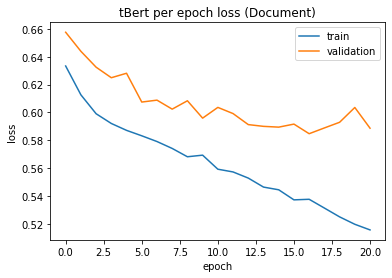

In [ ]:
plt.title("tBert per epoch loss (Document)")
plt.plot(trainlosslog,label = "train")
plt.plot(validlosslog,label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

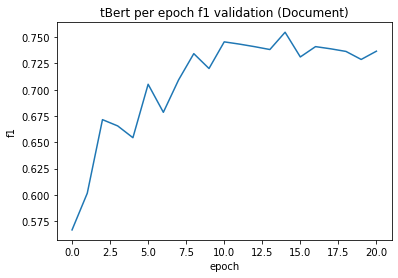

In [ ]:
plt.title("tBert per epoch f1 validation (Document)")
plt.plot(flog)
plt.xlabel("epoch")
plt.ylabel("f1")
plt.show()

In [47]:
#tbert
net = BertNetwork().to(device)
optimizer =  optim.Adam(net.parameters(), lr=lr)
early_stopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()


trainlosslog = []
validlosslog = []
es_flag = False
flog = []
for epoch in range(21):
    running_loss = 0.0  
    for i_batch, sample_batched in enumerate(dataloaders['train']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainlosslog.append(running_loss/i_batch)    
    
    
    
    running_loss_val = 0.0  
    y_true = np.array([])
    y_pred = np.array([])
    for i_batch, sample_batched in enumerate(dataloaders['validation']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
        y_true = np.append(y_true, sample_batched['label'])
        loss = criterion(out, label)
        running_loss_val += loss.item()

    validlosslog.append(running_loss_val/i_batch)    
    f = f1_score(y_true, y_pred, average='weighted')
    print('epoch %d -> loss train: %.3f  loss validation: %.3f f1 validation: %.3f'%(
               epoch+1, trainlosslog[-1], validlosslog[-1], f))
    flog.append(f)
    early_stopping(validlosslog[-1], f)
    if early_stopping.early_stop:
        es_flag = True
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our sugges

epoch 1 -> loss train: 0.643  loss validation: 0.669 f1 validation: 0.561
epoch 2 -> loss train: 0.629  loss validation: 0.666 f1 validation: 0.561
epoch 3 -> loss train: 0.627  loss validation: 0.663 f1 validation: 0.561
epoch 4 -> loss train: 0.626  loss validation: 0.662 f1 validation: 0.561
epoch 5 -> loss train: 0.622  loss validation: 0.657 f1 validation: 0.561
epoch 6 -> loss train: 0.620  loss validation: 0.655 f1 validation: 0.565
epoch 7 -> loss train: 0.619  loss validation: 0.653 f1 validation: 0.575
epoch 8 -> loss train: 0.616  loss validation: 0.652 f1 validation: 0.575
epoch 9 -> loss train: 0.615  loss validation: 0.649 f1 validation: 0.601
epoch 10 -> loss train: 0.612  loss validation: 0.649 f1 validation: 0.601
epoch 11 -> loss train: 0.611  loss validation: 0.648 f1 validation: 0.610
epoch 12 -> loss train: 0.609  loss validation: 0.646 f1 validation: 0.608
epoch 13 -> loss train: 0.608  loss validation: 0.645 f1 validation: 0.616
epoch 14 -> loss train: 0.606  los

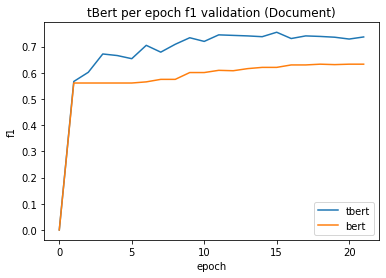

In [54]:
plt.title("tBert per epoch f1 validation (Document)")
plt.plot(tbertflog, label = "tbert")
plt.plot(flog, label = "bert")
plt.xlabel("epoch")
plt.ylabel("f1")
plt.legend()
plt.show()

In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/proj_net_document_v")

In [23]:
y_true = np.array([])
y_pred = np.array([])
for i_batch, sample_batched in enumerate(dataloaders['test']):
    s1 = sample_batched['sentence1']
    s2 = sample_batched['sentence2']
    label = sample_batched['label'].to(device)
    out = net(s1,s2, True)
    y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
    y_true = np.append(y_true, sample_batched['label'])
f = f1_score(y_true, y_pred, average='weighted')
print("test f1:" + str(f))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

test f1:0.7933604450098724


In [ ]:
#tbert
net = tBertNetwork().to(device)
optimizer =  optim.Adam(net.parameters(), lr=lr)
early_stopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()


trainlosslog = []
validlosslog = []
es_flag = False
flog = []
for epoch in range(100):
    running_loss = 0.0  
    for i_batch, sample_batched in enumerate(dataloaders['train']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, False)
        
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainlosslog.append(running_loss/i_batch)    
    
    
    
    running_loss_val = 0.0  
    y_true = np.array([])
    y_pred = np.array([])
    for i_batch, sample_batched in enumerate(dataloaders['validation']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, False)
        y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
        y_true = np.append(y_true, sample_batched['label'])
        loss = criterion(out, label)
        running_loss_val += loss.item()

    validlosslog.append(running_loss_val/i_batch)    
    f = f1_score(y_true, y_pred, average='weighted')
    print('epoch %d -> loss train: %.3f  loss validation: %.3f f1 validation: %.3f'%(
               epoch+1, trainlosslog[-1], validlosslog[-1], f))
    flog.append(f)
    early_stopping(validlosslog[-1], f)
    if early_stopping.early_stop:
        es_flag = True
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our sugges

epoch 1 -> loss train: 0.634  loss validation: 0.660 f1 validation: 0.565
epoch 2 -> loss train: 0.613  loss validation: 0.641 f1 validation: 0.625
epoch 3 -> loss train: 0.601  loss validation: 0.633 f1 validation: 0.639
epoch 4 -> loss train: 0.593  loss validation: 0.623 f1 validation: 0.666
epoch 5 -> loss train: 0.588  loss validation: 0.622 f1 validation: 0.697
epoch 6 -> loss train: 0.584  loss validation: 0.613 f1 validation: 0.691
epoch 7 -> loss train: 0.580  loss validation: 0.618 f1 validation: 0.663
epoch 8 -> loss train: 0.575  loss validation: 0.604 f1 validation: 0.694
epoch 9 -> loss train: 0.574  loss validation: 0.599 f1 validation: 0.703
epoch 10 -> loss train: 0.568  loss validation: 0.599 f1 validation: 0.736
epoch 11 -> loss train: 0.563  loss validation: 0.595 f1 validation: 0.738
epoch 12 -> loss train: 0.565  loss validation: 0.595 f1 validation: 0.709
epoch 13 -> loss train: 0.556  loss validation: 0.597 f1 validation: 0.744
epoch 14 -> loss train: 0.553  los

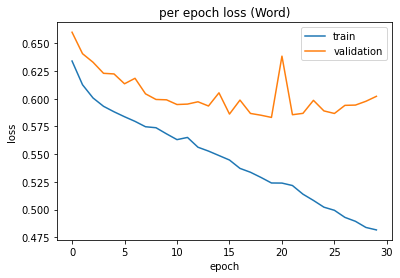

In [ ]:
plt.title("per epoch loss (Word)")
plt.plot(trainlosslog,label = "train")
plt.plot(validlosslog,label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

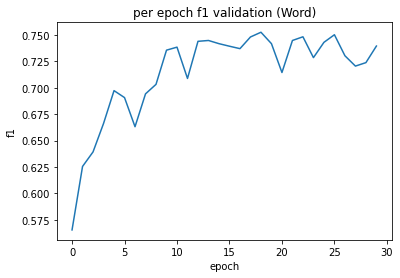

In [ ]:
plt.title("per epoch f1 validation (Word)")
plt.plot(flog)
plt.xlabel("epoch")
plt.ylabel("f1")
plt.show()

In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/proj_net_word_v")

Bert 21 to 30

In [55]:
for epoch in range(9):
    running_loss = 0.0  
    for i_batch, sample_batched in enumerate(dataloaders['train']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainlosslog.append(running_loss/i_batch)    
    
    
    
    running_loss_val = 0.0  
    y_true = np.array([])
    y_pred = np.array([])
    for i_batch, sample_batched in enumerate(dataloaders['validation']):

        s1 = sample_batched['sentence1']
        s2 = sample_batched['sentence2']
        label = sample_batched['label'].to(device)
        optimizer.zero_grad()


        out = net(s1,s2, True)
        y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
        y_true = np.append(y_true, sample_batched['label'])
        loss = criterion(out, label)
        running_loss_val += loss.item()

    validlosslog.append(running_loss_val/i_batch)    
    f = f1_score(y_true, y_pred, average='weighted')
    print('epoch %d -> loss train: %.3f  loss validation: %.3f f1 validation: %.3f'%(
               epoch+1, trainlosslog[-1], validlosslog[-1], f))
    flog.append(f)
    early_stopping(validlosslog[-1], f)
    if early_stopping.early_stop:
        es_flag = True
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

epoch 1 -> loss train: 0.599  loss validation: 0.635 f1 validation: 0.631
epoch 2 -> loss train: 0.599  loss validation: 0.635 f1 validation: 0.640
epoch 3 -> loss train: 0.598  loss validation: 0.636 f1 validation: 0.650
epoch 4 -> loss train: 0.598  loss validation: 0.633 f1 validation: 0.650
epoch 5 -> loss train: 0.597  loss validation: 0.633 f1 validation: 0.643
epoch 6 -> loss train: 0.596  loss validation: 0.632 f1 validation: 0.650
epoch 7 -> loss train: 0.596  loss validation: 0.633 f1 validation: 0.640
epoch 8 -> loss train: 0.595  loss validation: 0.633 f1 validation: 0.654
epoch 9 -> loss train: 0.595  loss validation: 0.633 f1 validation: 0.662


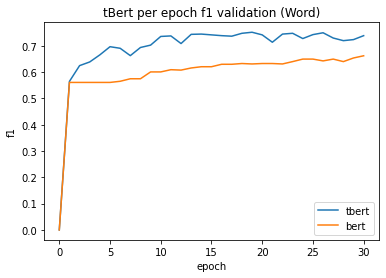

In [58]:
plt.title("tBert per epoch f1 validation (Word)")
plt.plot(tbertflog, label = "tbert")
plt.plot(flog, label = "bert")
plt.xlabel("epoch")
plt.ylabel("f1")
plt.legend()
plt.show()

In [25]:
y_true = np.array([])
y_pred = np.array([])
for i_batch, sample_batched in enumerate(dataloaders['test']):
    s1 = sample_batched['sentence1']
    s2 = sample_batched['sentence2']
    label = sample_batched['label'].to(device)
    out = net(s1,s2, False)
    y_pred = np.append(y_pred, np.array(np.argmax(out.cpu().detach().numpy(),axis = 1)))
    y_true = np.append(y_true, sample_batched['label'])
f = f1_score(y_true, y_pred, average='weighted')
print("test f1:" + str(f))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

test f1:0.7412526208536979
